# Union Investment - Financial Modeling of the Equity Market

# 0. Write Functions

In [1]:
def flatten(x):
    ''' 
    Creates a generator object that loops through a nested array.
  
    Parameters:
    ----------
    x - A nested array.

    Returns: 
    ----------
    j - A flattened array.
    '''
    
    # Check if the array is iterable
    try:
        narray = iter(x)
    # If it is not iterable, return the array
    except TypeError:
        yield x
    # If it is iterable, loop through the array recursively
    else:
        for i in narray:
            for j in flatten(i):
                yield j

# 0. Load Libraries

In [2]:
# suppress future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np

import pandas as pd

from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

import seaborn as sns


from feature_engine import outlier_removers as outr

from imblearn.over_sampling import SMOTE


import statsmodels.api as sm

import sklearn

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn import preprocessing

from sklearn.feature_selection import RFE

import eli5

from eli5.sklearn import PermutationImportance


# display all columns
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# 1. Data

### Import 

In [3]:
# Import data
data_raw = pd.read_csv("Input_Data_for_Candidate.csv").set_index('Date')

# Change type of response variable
data_raw['Target'] = data_raw['Target'].astype('category')

# Change order of the columns
cols = data_raw.columns.tolist()
cols = cols[1:] + cols[0:1]
data_raw = data_raw[cols]

### Extract information 

In [4]:
# Show number of rows and columns
print("Rows, Columns:");print(data_raw.shape);print("\n")

# Show column names
print("Columns:");print(data_raw.columns);print("\n")

# Show info
print("Info:");print(data_raw.info()); print("\n")

# Count Non-NaNs per indicator
print("Non-NaN per indicator:");print(data_raw.count()); print("\n")

# Count NaNs per indicator
print("NaN per indicator:");print(data_raw.isna().sum());print("\n")

# Sum NaNs 
print("total NaN values: ", data_raw.isna().sum().sum(),'\n')

# Show head
print("Head");print(data_raw.head()); print("\n")

# Show tail
print("Tail");print(data_raw.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(data_raw.describe());print("\n")

Rows, Columns:
(15119, 28)


Columns:
Index(['Indikator1', 'Indikator2', 'Indikator3', 'Indikator4', 'Indikator5',
       'Indikator6', 'Indikator7', 'Indikator8', 'Indikator9', 'Indikator10',
       'Indikator11', 'Indikator12', 'Indikator13', 'Indikator14',
       'Indikator15', 'Indikator16', 'Indikator17', 'Indikator18',
       'Indikator19', 'Indikator20', 'Indikator21', 'Indikator22',
       'Indikator23', 'Indikator24', 'Indikator25', 'Indikator26',
       'Indikator27', 'Target'],
      dtype='object')


Info:
<class 'pandas.core.frame.DataFrame'>
Index: 15119 entries, 1960-01-04 to 2020-01-27
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Indikator1   15118 non-null  float64 
 1   Indikator2   15118 non-null  float64 
 2   Indikator3   15118 non-null  float64 
 3   Indikator4   15119 non-null  float64 
 4   Indikator5   15119 non-null  float64 
 5   Indikator6   15119 non-null  float64 
 6   Indikator

### NaNs

In [5]:
# Drop rows with NaNs
data = data_raw.dropna(how='any')

# Show shape of dataframe before removing NaNs
print("old dataframe shape: ", data_raw.shape)

# Show number of missing values
print("total NaN values: ", data_raw.isna().sum().sum(),'\n')

# Show shape of dataframe after removing NaNs
print("new dataframe shape: ", data.shape)

# Show number of missing values
print("total NaN values: ", data.isna().sum().sum(),'\n')

# Show how much data we lost 
print("--> we lost %s Non-NaN values;" %
      ((data_raw.shape[0]*data_raw.shape[1]) - (data.shape[0]*data.shape[1]) - data_raw.isna().sum().sum()), 'which corresponds to only', 
      np.round(np.multiply(np.divide(((data_raw.shape[0]*data_raw.shape[1]) - (data.shape[0]*data.shape[1]) + data.isna().sum().sum()),
      data_raw.shape[0]*data_raw.shape[1]),100),2), '% of our data')

old dataframe shape:  (15119, 28)
total NaN values:  20 

new dataframe shape:  (15117, 28)
total NaN values:  0 

--> we lost 36 Non-NaN values; which corresponds to only 0.01 % of our data


### Check whether data is balanced

In [6]:
# Show number of ups 
print("Number of ups",sum(data['Target']==1))

# Show % of ups 
print("Percentage of ups",np.round(sum(data['Target']==1)/data['Target'].count()*100), '%'); print("\n")

# Show number of downs 
print("Number of dows",sum(data['Target']==0))

# Show % of downs 
print("Percentage of downs",np.round(sum(data['Target']==0)/data['Target'].count()*100), '%')

Number of ups 7988
Percentage of ups 53.0 %


Number of dows 7129
Percentage of downs 47.0 %


### Visualizations

#### Indicator Distributions

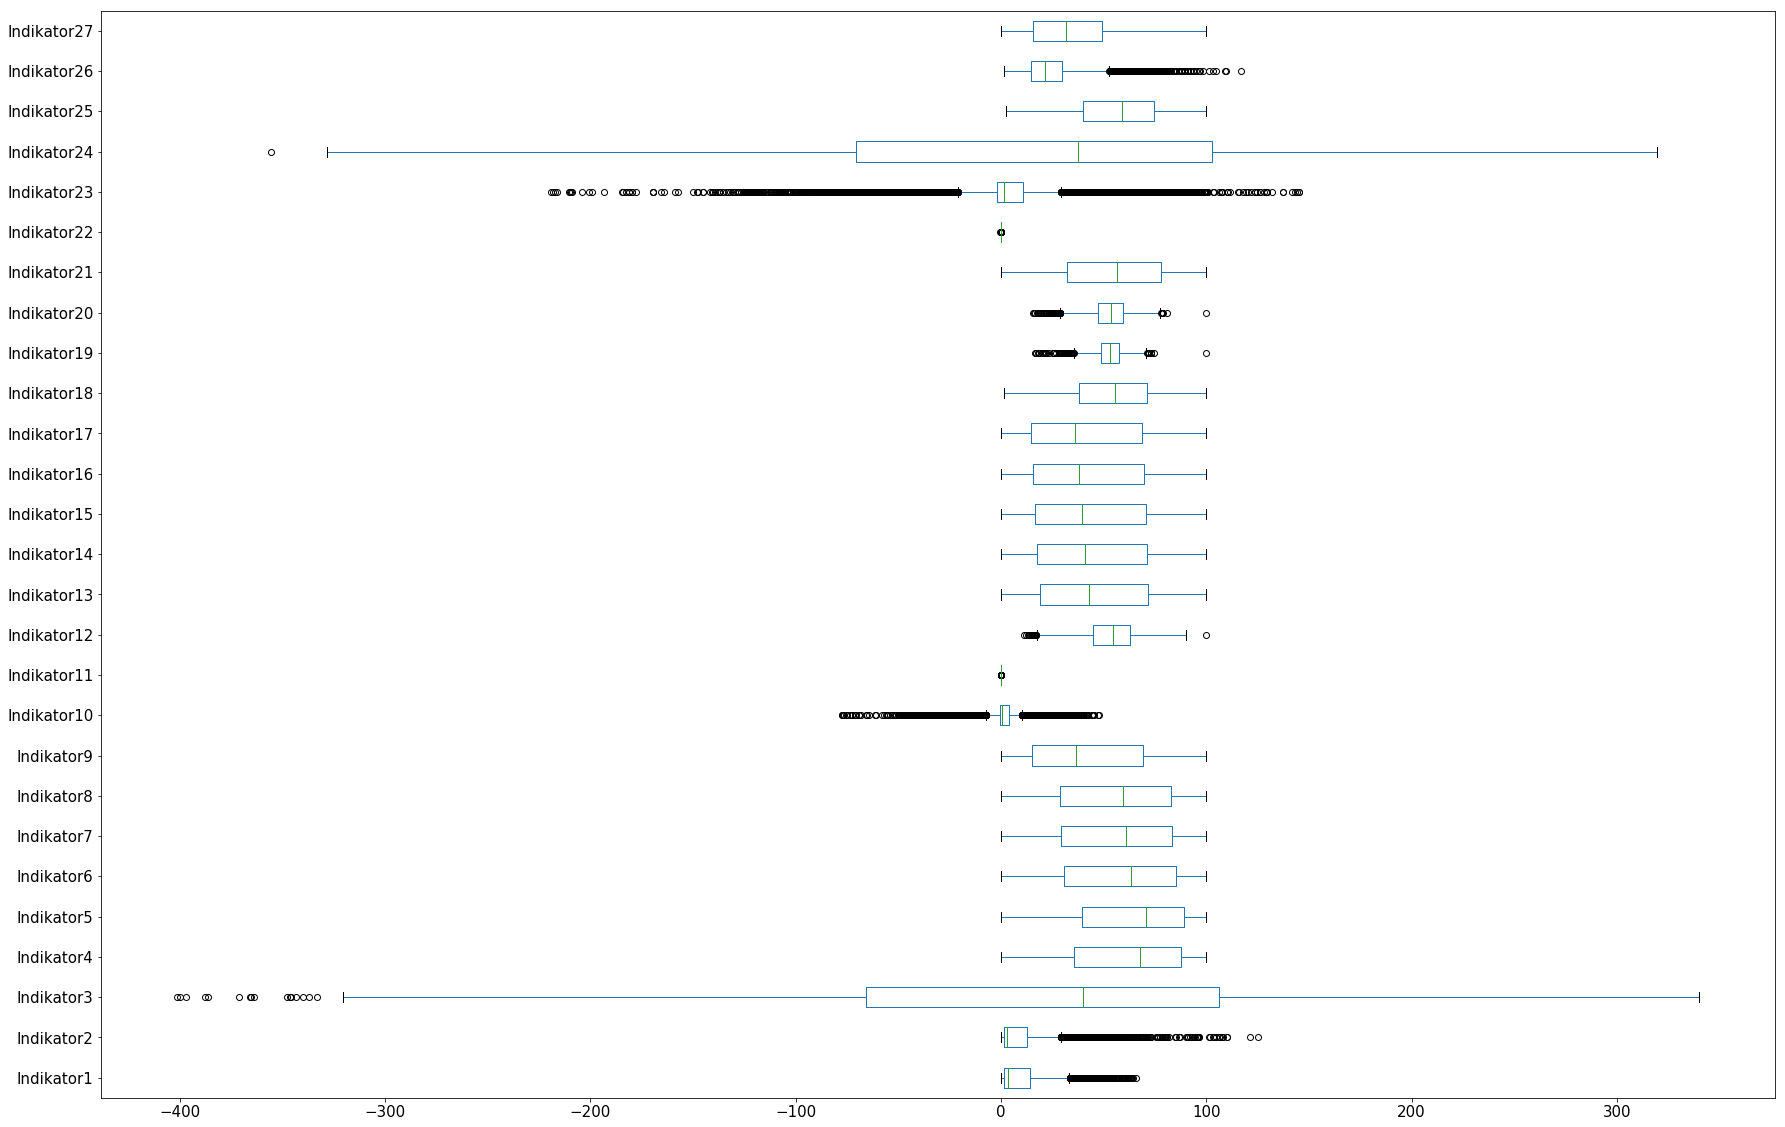

In [7]:
# Plot distributions of indicators 
data.plot.box(vert=False, figsize=(30,20), fontsize=15);

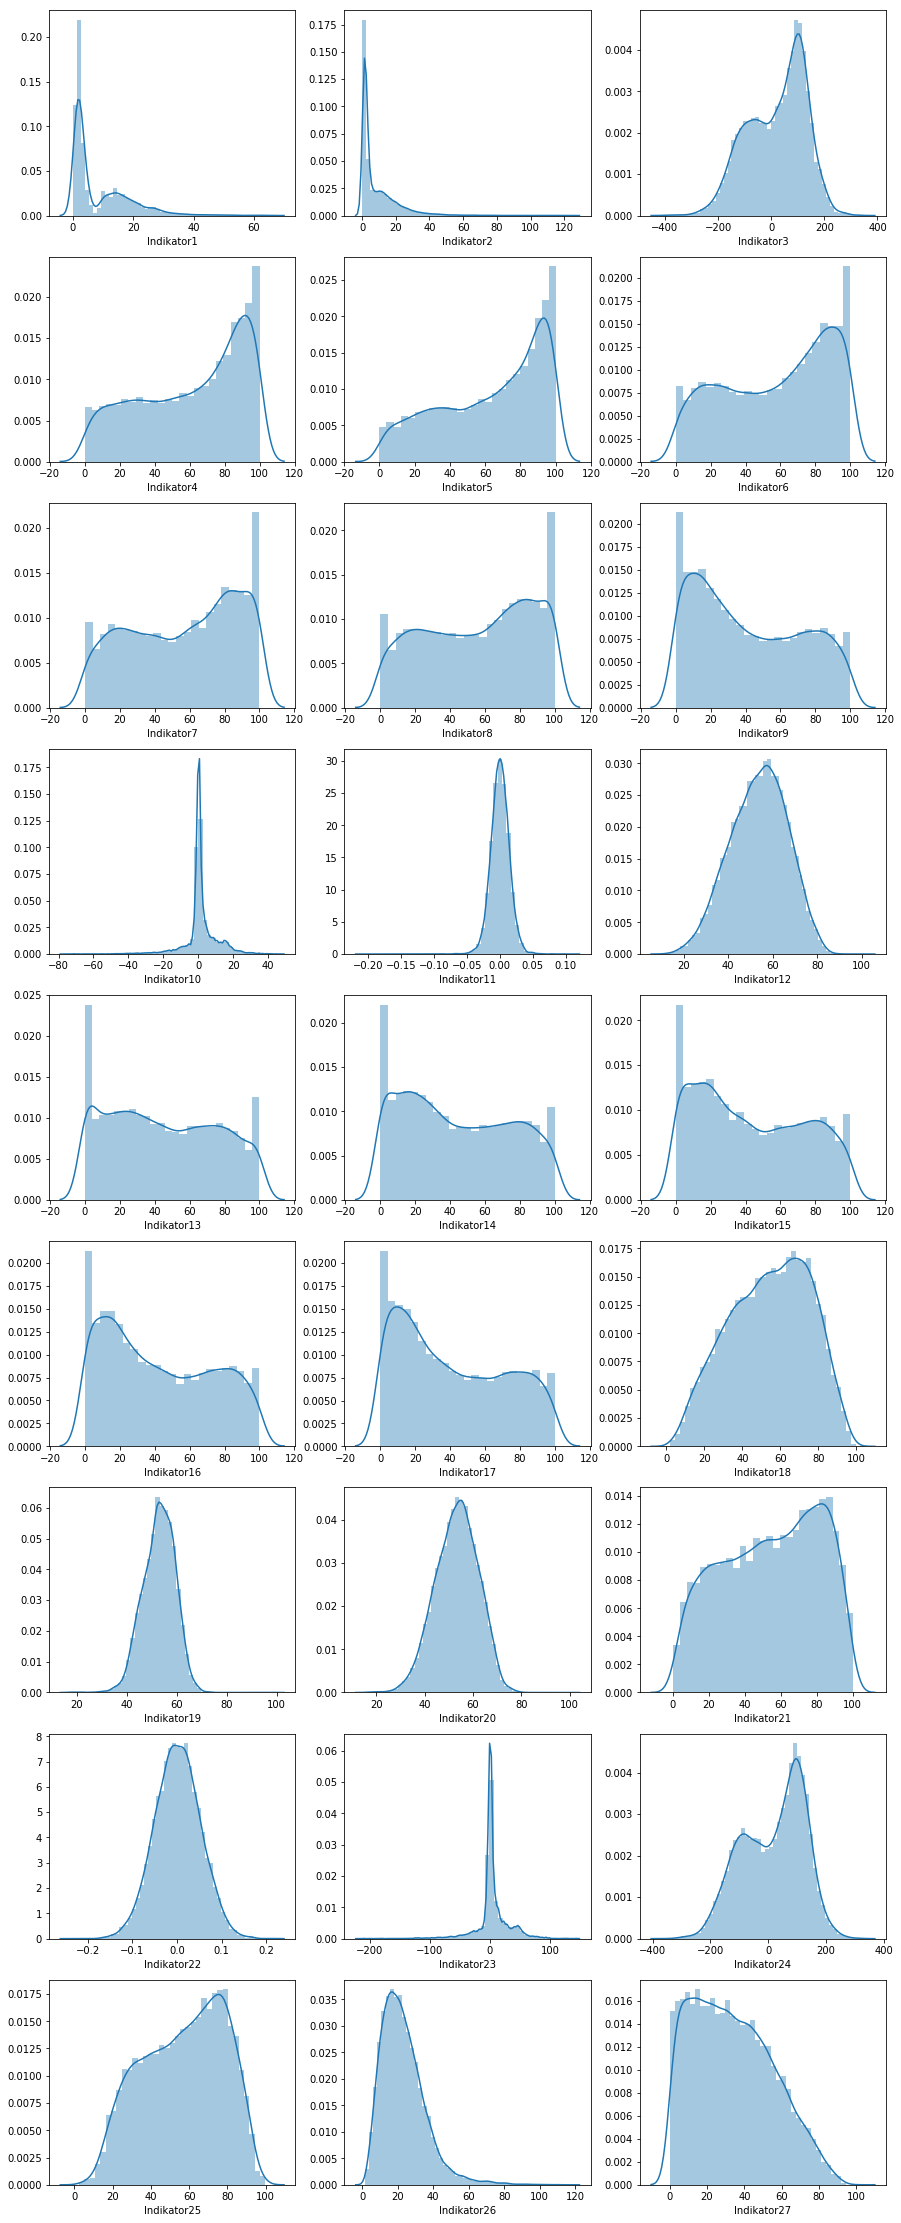

In [8]:
# Plot distributions of indicators 
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15,40))
for ax, col in zip(flatten(axes), data.iloc[:,:-1].columns):
    sns.distplot(data[col], ax=ax)

#### Indicator correlation matrix

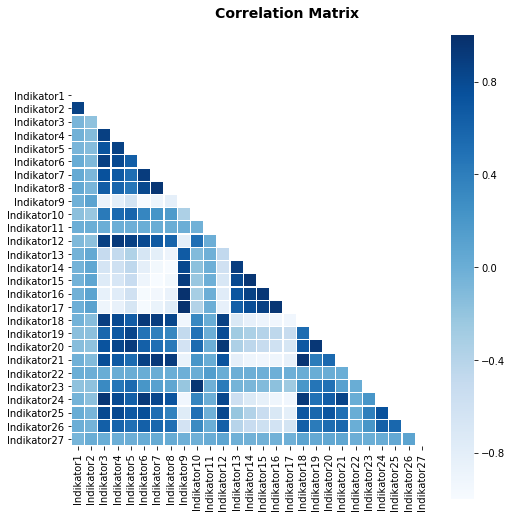

In [9]:
# Plot correlation matrix of indicators 
corr=data.iloc[:,0:27].corr()

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(8,8))

heat=sns.heatmap(corr, 
                 ax=ax, 
                 mask=mask, 
                 vmax=1, 
                 square=True, 
                 linewidths=.2, 
                 cmap="Blues")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Correlation Matrix', fontsize=14, fontweight='bold')

plt.savefig('heat1.eps', dpi=200, format='eps');

#### Indicator-Target Relationships

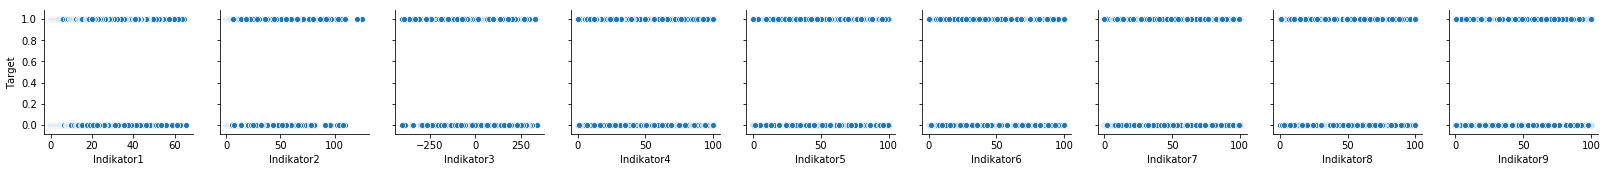

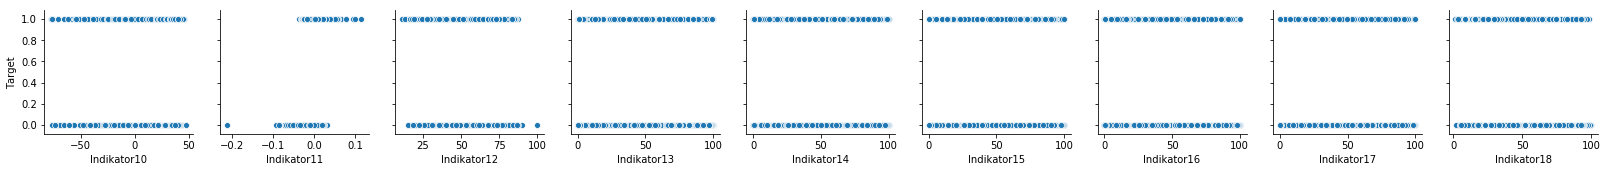

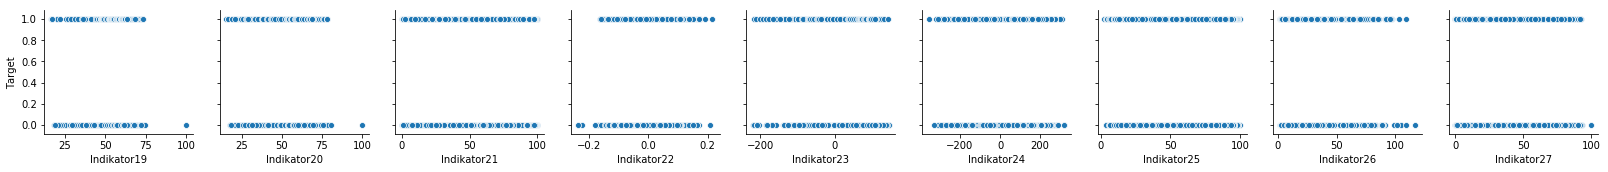

In [10]:
# Plot indicator-target Relationships
sns.pairplot(data=data,
             y_vars=['Target'],
             x_vars=data.iloc[:,0:9].columns);
sns.pairplot(data=data,
             y_vars=['Target'],
             x_vars=data.iloc[:,9:18].columns);
sns.pairplot(data=data,
             y_vars=['Target'],
             x_vars=data.iloc[:,18:27].columns);

### Define features and response variable

In this notebook, will consider the following:
1. Raw data
2. Winsorized data
3. Scaled data
4. Winsorized + scaled data

### Raw data

In [11]:
# Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], 
                                                    data.iloc[:,-1], 
                                                    test_size=0.1, 
                                                    shuffle=False)

### Winsorizing

In [12]:
# set up the capper
cap = outr.Winsorizer(
      distribution='skewed', tail='both', fold=3, variables=data.iloc[:,:-1].columns.tolist())
#-->If a data point is below Q1 – 3×IQR or above Q3 + 3×IQR, it is viewed as too far from central to be reasonable. 

# fit training data
cap.fit(x_train)

# transform training and test data
x_train_w = cap.transform(x_train)
x_test_w = cap.transform(x_test)

### Scaling

In [13]:
# set up the scaler 
sc = StandardScaler()

# fit and transform training data
x_train_s = sc.fit_transform(x_train)

# transform test data
x_test_s = sc.transform(x_test)

### Winsorizing + Scaling

In [14]:
# Winsorize and scale training data (fit and transform)
x_train_ws = sc.fit_transform(x_train_w)

# Winsorize and scale test data (transform)
x_test_ws = sc.transform(x_test_w)

# 2. Logistic Regression

## 2.1 Raw data

### Fit Logistic Model

In [15]:
# Fit logistic regression
log_reg_1 = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_1.fit(x_train, y_train);

### Perform Predictions 

In [16]:
# Perform predictions
log_pre_1 = log_reg_1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_1))

Accuracy: 0.6706349206349206


### Confusion Matrix

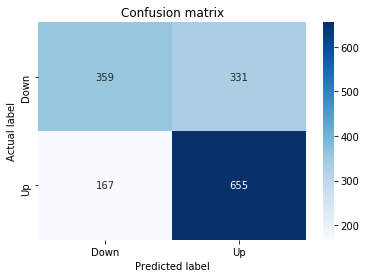

In [17]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_1)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']);ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [18]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_1))

              precision    recall  f1-score   support

         0.0       0.68      0.52      0.59       690
         1.0       0.66      0.80      0.72       822

    accuracy                           0.67      1512
   macro avg       0.67      0.66      0.66      1512
weighted avg       0.67      0.67      0.66      1512



### Roc Curve

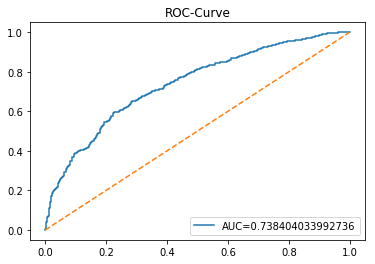

In [19]:
# Create Roc Curve
log_prob_1 = log_reg_1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_1)
auc = metrics.roc_auc_score(y_test.values, log_prob_1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## 2.2 Winsorized data

### Fit Logistic Model

In [20]:
# Fit logistic regression
log_reg_2 = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_2.fit(x_train_w, y_train);

### Perform Predictions 

In [21]:
# Perform predictions
log_pre_2 = log_reg_2.predict(x_test_w)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_2))

Accuracy: 0.669973544973545


### Confusion Matrix

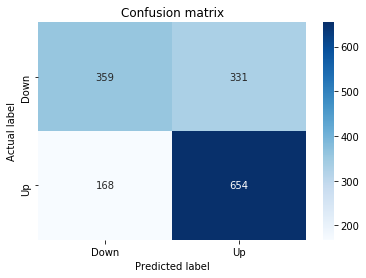

In [22]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_2)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [23]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_2))

              precision    recall  f1-score   support

         0.0       0.68      0.52      0.59       690
         1.0       0.66      0.80      0.72       822

    accuracy                           0.67      1512
   macro avg       0.67      0.66      0.66      1512
weighted avg       0.67      0.67      0.66      1512



### Roc Curve

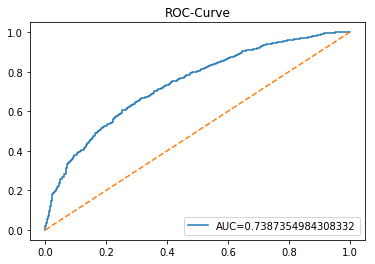

In [24]:
# Create Roc Curve
log_prob_2 = log_reg_2.predict_proba(x_test_w)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_2)
auc = metrics.roc_auc_score(y_test.values, log_prob_2)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## 2.3 Scaled data

### Fit Logistic Model 

In [25]:
# Fit logistic regression 
log_reg_3 = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_3.fit(x_train_s, y_train);

### Perform Predictions 

In [26]:
# Perform predictions
log_pre_3 = log_reg_3.predict(x_test_s)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_3))

Accuracy: 0.7043650793650794


### Confusion Matrix

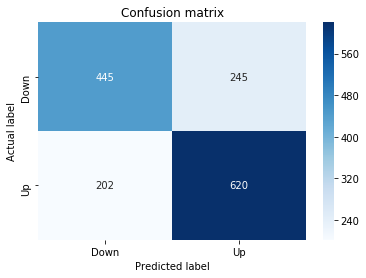

In [27]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_3)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [28]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_3))

              precision    recall  f1-score   support

         0.0       0.69      0.64      0.67       690
         1.0       0.72      0.75      0.74       822

    accuracy                           0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.70      0.70      0.70      1512



### Roc Curve

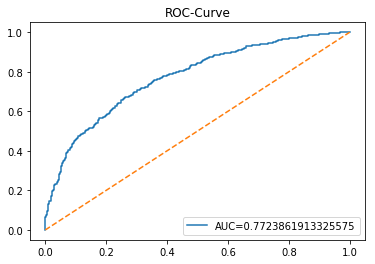

In [29]:
# Create Roc Curve
log_prob_3 = log_reg_3.predict_proba(x_test_s)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_3)
auc = metrics.roc_auc_score(y_test.values, log_prob_3)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## 2.4 Winsorized + scaled data

### Fit Logistic Model

In [30]:
# Fit logistic regression 
log_reg_4 = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_4.fit(x_train_ws, y_train);

### Perform Predictions 

In [31]:
# Perform predictions
log_pre_4 = log_reg_4.predict(x_test_ws)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_4))

Accuracy: 0.6977513227513228


### Confusion Matrix

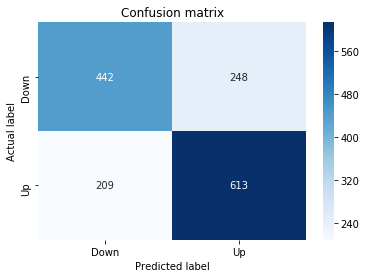

In [32]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_4)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [33]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_4))

              precision    recall  f1-score   support

         0.0       0.68      0.64      0.66       690
         1.0       0.71      0.75      0.73       822

    accuracy                           0.70      1512
   macro avg       0.70      0.69      0.69      1512
weighted avg       0.70      0.70      0.70      1512



### Roc Curve

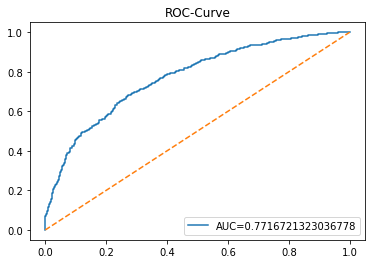

In [34]:
# Create Roc Curve
log_prob_4 = log_reg_4.predict_proba(x_test_ws)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_4)
auc = metrics.roc_auc_score(y_test.values, log_prob_4)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# 3. Logistic Regression - Over-sampling of minority class (downs) 

### Over-sample minority class (downs)

In [35]:
# Set over-sampler
os = SMOTE(random_state=0)

# Fit over-sampler
x_train_os, y_train_os = os.fit_sample(x_train, y_train.values)

# Save over-sampled training data
x_train_os = pd.DataFrame(data=x_train_os,columns=x_train.columns)
y_train_os = pd.DataFrame(data=y_train_os, columns=['Target'])

# Verify over-sampling
print('Before Over-sampling:', )
print("Number of ups",np.sum(y_train==1))
print("Number of downs",np.sum(y_train==0));print("\n")

print('After Over-sampling:')
print("Number of ups",np.sum(y_train_os.values==1))
print("Number of downs",np.sum(y_train_os.values==0))

Before Over-sampling:
Number of ups 7166
Number of downs 6439


After Over-sampling:
Number of ups 7166
Number of downs 7166


## 3.1 Raw data

### Fit Logistic Model

In [36]:
# Fit logistic regression 
log_reg_os_1 = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_os_1.fit(x_train_os, y_train_os.values.ravel());

### Perform Predictions 

In [37]:
# Perform predictions
log_pre_os_1 = log_reg_os_1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_os_1))

Accuracy: 0.673941798941799


### Confusion Matrix

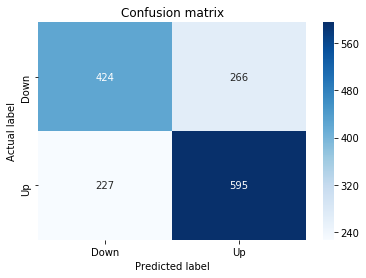

In [38]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_os_1)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [39]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_os_1))

              precision    recall  f1-score   support

         0.0       0.65      0.61      0.63       690
         1.0       0.69      0.72      0.71       822

    accuracy                           0.67      1512
   macro avg       0.67      0.67      0.67      1512
weighted avg       0.67      0.67      0.67      1512



### Roc Curve

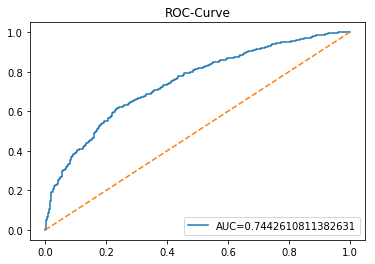

In [40]:
# Create Roc Curve
log_prob_os_1 = log_reg_os_1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_os_1)
auc = metrics.roc_auc_score(y_test.values, log_prob_os_1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## 3.2 Winsorized data

### Winsorizing

In [41]:
# set up the capper
cap = outr.Winsorizer(
      distribution='skewed', tail='both', fold=3, variables=data.iloc[:,:-1].columns.tolist())
#-->If a data point is below Q1 – 3×IQR or above Q3 + 3×IQR, it is viewed as too far from central to be reasonable. 

# fit training data
cap.fit(x_train_os)

# transform training and test data
x_train_os_w = cap.transform(x_train_os)
x_test_os_w = cap.transform(x_test)

### Fit Logistic Model 

In [42]:
# Fit logistic regression 
log_reg_os_2 = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_os_2.fit(x_train_os_w, y_train_os.values.ravel());

### Perform Predictions 

In [43]:
# Perform predictions
log_pre_os_2 = log_reg_os_2.predict(x_test_os_w)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_os_2))

Accuracy: 0.6746031746031746


### Confusion Matrix

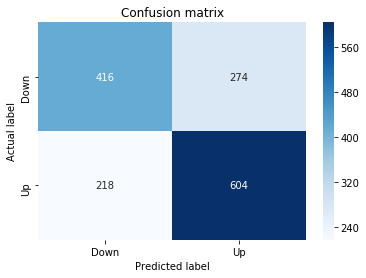

In [44]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_os_2)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [45]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_os_2))

              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63       690
         1.0       0.69      0.73      0.71       822

    accuracy                           0.67      1512
   macro avg       0.67      0.67      0.67      1512
weighted avg       0.67      0.67      0.67      1512



### Roc Curve

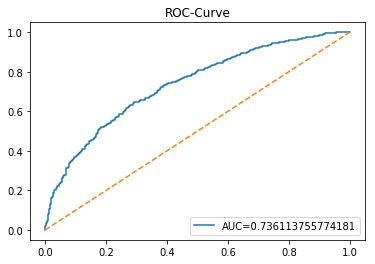

In [46]:
# Create Roc Curve
log_prob_os_2 = log_reg_os_2.predict_proba(x_test_os_w)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_os_2)
auc = metrics.roc_auc_score(y_test.values, log_prob_os_2)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## 3.3 Scaled data

### Scaling

In [47]:
# set up the scaler 
sc = StandardScaler()

# fit and transform training data
x_train_os_s = sc.fit_transform(x_train_os)

# transform test data
x_test_os_s = sc.transform(x_test)

### Fit Logistic Model 

In [48]:
# Fit logistic regression 
log_reg_os_3 = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_os_3.fit(x_train_os_s, y_train_os.values.ravel());

### Perform Predictions 

In [49]:
# Perform predictions
log_pre_os_3 = log_reg_os_3.predict(x_test_os_s)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_os_3))

Accuracy: 0.7017195767195767


### Confusion Matrix

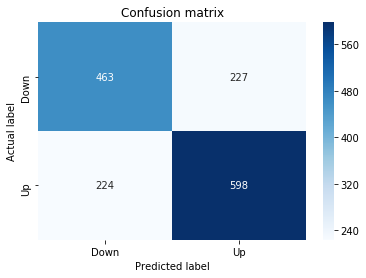

In [50]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_os_3)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [51]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_os_3))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67       690
         1.0       0.72      0.73      0.73       822

    accuracy                           0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.70      0.70      0.70      1512



### Roc Curve

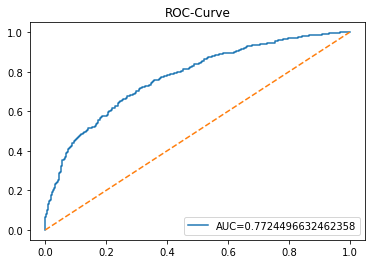

In [52]:
# Create Roc Curve
log_prob_os_3 = log_reg_os_3.predict_proba(x_test_os_s)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_os_3)
auc = metrics.roc_auc_score(y_test.values, log_prob_os_3)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

## 3.4 Winsorized + scaled data

### Winsorizing + Scaling

In [53]:
# Winsorize and scale training data (fit and transform)
x_train_os_ws = sc.fit_transform(x_train_os_w)

# Winsorize and scale test data (transform)
x_test_os_ws = sc.transform(x_test)

### Fit Logistic Model 

In [54]:
# Fit logistic regression 
log_reg_os_4 = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_os_4.fit(x_train_os_ws, y_train_os.values.ravel());

### Perform Predictions 

In [55]:
# Perform predictions
log_pre_os_4 = log_reg_os_4.predict(x_test_os_ws)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_os_4))

Accuracy: 0.6984126984126984


### Confusion Matrix

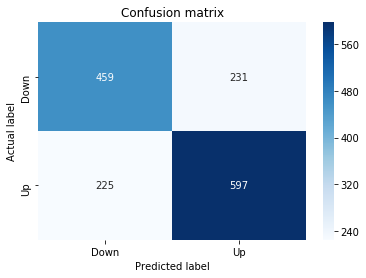

In [56]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_os_4)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [57]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_os_4))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67       690
         1.0       0.72      0.73      0.72       822

    accuracy                           0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.70      0.70      0.70      1512



### Roc Curve

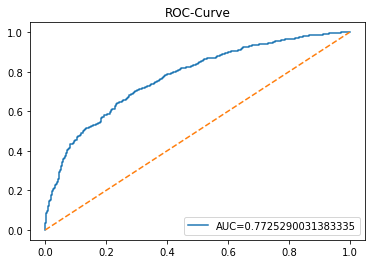

In [58]:
# Create Roc Curve
log_prob_os_4 = log_reg_os_4.predict_proba(x_test_os_ws)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_os_4)
auc = metrics.roc_auc_score(y_test.values, log_prob_os_4)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# 4. Logistic Regression - Feature Selection - RFE

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and weights are assigned to each one of them. Then, features whose absolute weights are the smallest are pruned from the current set features. That procedure is recursively repeated on the pruned set until the **optimal number of features to select** is eventually reached. 

Proper **scaling is crucial** for the RFE method to work with LogisticRegression as desired. This is in stark contrast to the LogisticRegression model's performance immunity against scaling.

Reference: An Introduction to Variable and Feature Selection: http://jmlr.org/papers/volume3/guyon03a/guyon03a.pdf

**-->In this notebook, we use the walk-forward-validation set approach, to find the optimal number of features to select**

### Workflow

<img src="work-flow.png" width="800" />

Source: Own illustration

### Hyperparameter

Important Hyperparameter: 
1. Number of features to select


### Walk Forward Validation Approach

Time Series cross-validator provides train/dev indices to split time series data samples that are observed at fixed time intervals, in train/dev sets. In each split, dev indices must be higher than before, and thus shuffling in cross validator is inappropriate. The following graph illustrates how the time series split works:


<img src="walk-forward.png" width="800" />

Source: Own illustration

### Configuration for Walk-forward validation

In [73]:
# Walk-forward validation
dev_size=0.1 
n_splits=int((1//dev_size)-1)   # using // for integer division
tscv=TimeSeriesSplit(n_splits=n_splits) 

# Print number of splits
print('we consider', n_splits, 'splits' )

we consider 8 splits


The splitting of the data set during walk-forward-validation should be done before doing any preprocessing. Any process that extracts knowledge from the dataset should only ever be applied to the training portion of the data set. <br>

<img src="scaling.png" width="800" />

Source: Own illustration <br>


**The preprocessing includes the following steps:** <br>
**Step 0**: The data is split into TRAINING data and VALIDATION data according to the cv parameter that we specified in the GridSearchCV or RandomizedSearchCV <br>
**Step 1**: the scaler is fitted on the TRAINING data <br>
**Step 2**: the scaler transforms TRAINING data <br>
**Step 3**: the models are fitted/trained using the transformed TRAINING data <br>
**Step 4**: the scaler is used to transform the VALIDATION data <br>
**Step 5**: the trained models predict using the transformed VALIDATION data <br>
**Step 6**: the scaler is fitted on the TRAINING and VALIDATION data <br>
**Step 7**: the scaler transforms TRAINING and VALIDATION data <br>
**Step 8**: the model is fitted/trained using the transformed TRAINING and VALIDATION data and the best found parameters during Walk-Forward Validation<br>
**Step 9**: the scaler transforms TEST data <br>
**Step 10**: the trained model predicts using the transformed TEST data <br>

### Configuration of the necessary steps

In [60]:
# Set up Classifier
clf = LogisticRegression(solver='lbfgs', max_iter=10000, verbose=0)

# Set up Scaler
std_scaler = preprocessing.StandardScaler()

# Set up Selector
selector = RFE(clf)

# Define steps
steps = [('feat_selection',selector),
         ('scaler', std_scaler), 
         ('clf', clf)]

# Set up pipeline
pipeline = Pipeline(steps)

## 4.1 Scaled data --> relates to 2.3

### Fit Logistic Model 

In [110]:
# Set parameter grid 
param_grid_1 = dict(feat_selection__n_features_to_select=[1, 2, 5,10])

# Set up Gridsearch
log_reg_rfe_1 = GridSearchCV(estimator=pipeline, 
                param_grid=param_grid_1, 
                cv=tscv, 
                verbose=0, 
                n_jobs=-1, 
                scoring="accuracy", 
                refit=True, 
                return_train_score=False,
                iid=False)

# Fit the Classifier
log_reg_rfe_1.fit(x_train, np.ravel(y_train))

# Print number and list of selected features
print("Num indicators: %s" % (log_reg_rfe_1.best_estimator_.steps[0][1].n_features_))
print("Selected indicators: %s" % (x_train.iloc[:,log_reg_rfe_1.best_estimator_.steps[0][1].support_].columns.tolist()),'\n''\n')

Num indicators: 2
Selected indicators: ['Indikator11', 'Indikator22'] 




### Perform Predictions

In [113]:
log_pre_rfe_1 = log_reg_rfe_1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_rfe_1))

Accuracy: 0.7056878306878307


### Confusion Matrix

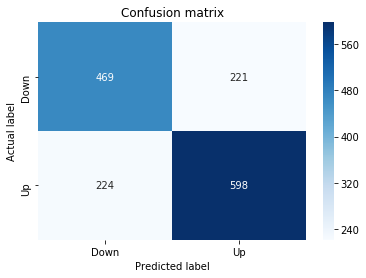

In [80]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_rfe_1)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']);ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [81]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_rfe_1))

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68       690
         1.0       0.73      0.73      0.73       822

    accuracy                           0.71      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.71      0.71      0.71      1512



### Roc Curve

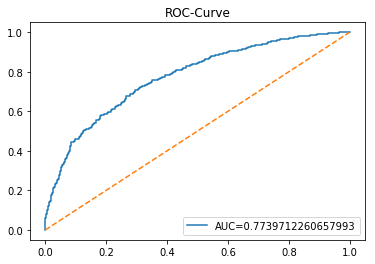

In [82]:
# Create Roc Curve
log_prob_rfe_1 = log_reg_rfe_1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_rfe_1)
auc = metrics.roc_auc_score(y_test.values, log_prob_rfe_1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# 5. Logistic Regression - Feature Selection - RFE - Over-sampling 

## 5.1  Scaled data --> relates to 3.3

### Fit Logistic Model 

In [83]:
# Set parameter grid 
param_grid_1 = dict(feat_selection__n_features_to_select=[1, 2, 5, 10])

# Set up Gridsearch
log_reg_os_rfe_1 = GridSearchCV(estimator=pipeline, 
                   param_grid=param_grid_1, 
                   cv=tscv, 
                   verbose=0, 
                   n_jobs=-1, 
                   scoring="accuracy", 
                   refit=True, 
                   return_train_score=False,
                   iid=False)

# Fit the Classifier
log_reg_os_rfe_1.fit(x_train_os, np.ravel(y_train_os))

# Print number and list of selected features
print("Num indicators: %s" % (log_reg_os_rfe_1.best_estimator_.steps[0][1].n_features_))
print("Selected indicators: %s" % (x_train_os.iloc[:,log_reg_os_rfe_1.best_estimator_.steps[0][1].support_].columns.tolist()),'\n''\n')

Num indicators: 2
Selected indicators: ['Indikator11', 'Indikator22'] 




### Perform Predictions

In [84]:
# Perform predictions
log_pre_os_rfe_1 = log_reg_os_rfe_1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, log_pre_os_rfe_1))

Accuracy: 0.7043650793650794


### Confusion Matrix

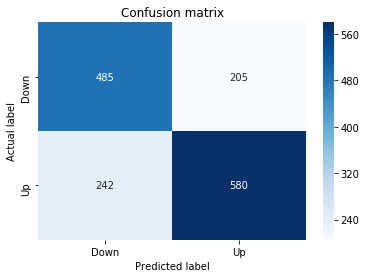

In [85]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, log_pre_os_rfe_1)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']);ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [86]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, log_pre_os_rfe_1))

              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68       690
         1.0       0.74      0.71      0.72       822

    accuracy                           0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.71      0.70      0.70      1512



### Roc Curve

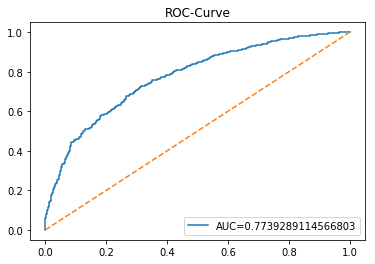

In [87]:
# Create Roc Curve
log_prob_os_rfe_1 = log_reg_os_rfe_1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_prob_os_rfe_1)
auc = metrics.roc_auc_score(y_test.values, log_prob_os_rfe_1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# 4. Logistic Regression - Feature Importance - Permutation  

model agnostic

Documentation: https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

Example: https://www.kaggle.com/dansbecker/permutation-importance

We can check the feature importance (with respect to the **training or validation set**) for any estimator that has already been fitted 

### Example 1:  model *log_reg_3* (2.3 Scaled data)

In [88]:
perm = PermutationImportance(log_reg_3).fit(pd.DataFrame(x_train_s), y_train)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.2040 ± 0.0148,Indikator11
0.0307 ± 0.0023,Indikator21
0.0202 ± 0.0041,Indikator18
0.0094 ± 0.0047,Indikator20
0.0079 ± 0.0040,Indikator12
0.0066 ± 0.0031,Indikator19
0.0063 ± 0.0020,Indikator22
0.0050 ± 0.0050,Indikator17
0.0032 ± 0.0028,Indikator9
0.0028 ± 0.0019,Indikator24


**--> Similar to the recursive feature elimination (RFE) method, we could:**

1. Use the validation set approach, to find the optimal threshold (weight)
2. Use the selected (weights > threshold) indicators to fit a model on training and validation data
3. Perform predictions on the test data

### Example 2: model *log_pre_os_3* (3.3 Scaled data - Over-sampling minority class)

In [90]:
perm = PermutationImportance(log_reg_os_3).fit(x_train_os_s, y_train_os.values.ravel())
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.2038 ± 0.0079,Indikator11
0.0343 ± 0.0056,Indikator21
0.0252 ± 0.0028,Indikator18
0.0123 ± 0.0021,Indikator20
0.0119 ± 0.0043,Indikator12
0.0074 ± 0.0032,Indikator19
0.0064 ± 0.0030,Indikator22
0.0061 ± 0.0031,Indikator17
0.0031 ± 0.0023,Indikator6
0.0026 ± 0.0027,Indikator9


## Logistic Regression - Permutation Selection

**--> Similar to the recursive feature elimination (RFE) method, we could:**

1. Use the validation set approach, to find the optimal threshold (weight)
2. Use the selected (weights > threshold) indicators to fit a model on training and validation data
3. Perform predictions on the test data